# Visualising Bayesian linear regression: Online learning

Previously we have introduced the [Bayesian approach to regression](regression-bayesian.ipynb) and visualised the resulting _predictive distribution_. In this section we visualise the _posterior distribution_ over the weights. By considering how the posterior evolves as data arrive one by one, we will develop an intuitive understanding of several important properties of Bayesian inference. 

The presentation also shows that probabilistic inference naturally provides so-called **online** or **incremental** updates. That is to say, an inference can be updated using the previous posterior distribution and the current data: it does not require the old data. Such updates are often faster and more memory efficient than **batch** updates which have to retain the whole dataset so that it can be accessed as new data arrive. They are particularly appealing when speed is important e.g. in high-frequency trading or in an autonomous robot that is continuously localising itself in an environment.    

### Recapitulating the model

Consider a scenario where we are fitting a regression model

$$\begin{align}
p(\mathbf{w},\mathbf{y},\mathbf{X} | \sigma_{\mathbf{w}}^2,\sigma_{y}^2) & = p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{X}) p(\mathbf{y}|\mathbf{X},\sigma_{y}^2) = p(\mathbf{w} | \sigma_{\mathbf{w}}^2) \prod_{n=1}^N p(x_n) p(y_n |\mathbf{w},\mathbf{x}_n,\sigma_{y}^2)\\
& = \mathcal{N}(\mathbf{w} ; \mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I}) \prod_{n=1}^N p(\mathbf{x}_n) \mathcal{N}(y_n; f^{(m)}_{\mathbf{w}}(\mathbf{x}),\sigma_{y}^2) \;\; \text{where} \;\; f_{\mathbf{w}}.(\mathbf{x})=\boldsymbol{\phi}(\mathbf{x})^\top \mathbf{w}.
\end{align}$$

We will suppress the parameters $\sigma_{\mathbf{w}}^2$ and $\sigma_y^2$ to lighten the notation.

## Inference through incremental updates

The data  $\{ \mathbf{x}_{n}, y_n \}$ arrive one after another and predictions are required after each datapoint is seen.  

Initially, before any data are seen, the prior $p(\mathbf{w})$ captures our knowledge about the weights $\mathbf{w}$. After one datapoint is observed Bayes' rule tells us that the posterior distribution over the weights is proportional to the prior times the likelihood from the datapoint:

$$\begin{align}
p(\mathbf{w}| y_1, \mathbf{x}_1) \propto p(\mathbf{w}) p(y_1| \mathbf{x}_1, \mathbf{w})
\end{align}$$

After two datapoints are seen the posterior is equal to the prior times the likelihood from the two datapoints

$$\begin{align}
p(\mathbf{w}| y_1, \mathbf{x}_1,y_2, \mathbf{x}_2) \propto p(\mathbf{w}) p(y_1| \mathbf{x}_1, \mathbf{w}) p(y_2| \mathbf{x}_2, \mathbf{w}, \sigma_y^2)
\end{align}$$

This can be rewritten in terms of the product of the posterior after seeing one datapoint and the likelihood from the second datapoint

$$\begin{align}
p(\mathbf{w}| y_1, \mathbf{x}_1,y_2, \mathbf{x}_2) \propto p(\mathbf{w}| y_1, \mathbf{x}_1) p(y_2| \mathbf{x}_2, \mathbf{w}).
\end{align}$$

Here **the previous posterior $p(\mathbf{w}| y_1, \mathbf{x}_1)$ plays the role of the new prior**. In retrospect this seems obvious as it follows directly from Bayes' rule: combine what you know about the parameters before seeing a new data point (the previous posterior) with the information coming from the datapoint (the new likelihood). 

The extension to $N$ datapoints is straightforward,

$$\begin{align}
p(\mathbf{w}| \{y_{n}, \mathbf{x}_{n}\}^N_{n = 1}) \propto p(\mathbf{w}| \{y_{n}, \mathbf{x}_{n}\}^{N-1}_{n = 1}) p(y_N| \mathbf{x}_N, \mathbf{w}).
\end{align}$$

At any point during the process the updated posterior can be used to make predictions in the usual way

$$\begin{align}
p(y^* | \mathbf{x}^*,  \{y_{n}, \mathbf{x}_{n}\}^N_{n = 1} ) = \int p(y^* | \mathbf{x}^*, \mathbf{w}) p(\mathbf{w}| \{y_{n}, \mathbf{x}_{n}\}^N_{n = 1}) d\mathbf{w}.
\end{align}$$

The updating scheme above is called  _online_ or _incremental_ because it only requires the old posterior to be stored, and not the old data  $\{y_{n}, \mathbf{x}_{n}\}^{N-1}_{n = 1}$. Although the expressions were computed with regression in mind, they are very general.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import HTML, set_matplotlib_formats
from utils import get_plot_title_bayesian_online_learning

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

%config InlineBackend.figure_format = 'svg'

We will work with the same dataset which we used for [linear regression](regression-linear.ipynb). However this time the data will be presented point by point to the model, which will adjust its posterior over weights accordingly.

In [2]:
# Load the data used for linear regression
x_data = np.load('reg_lin_x.npy')  
y_data = np.load('reg_lin_y.npy')

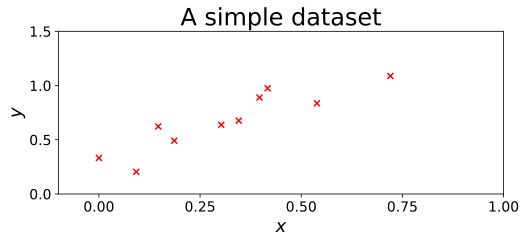

In [3]:
# Plot data
plt.figure(figsize=(8, 3))
plt.scatter(x_data, y_data, marker = 'x', color = 'red')

# Plot formatting
plt.title("A simple dataset", fontsize=24)
plt.xlabel("$x$", fontsize=18)

plt.ylabel("$y$", fontsize=18)
plt.xlim((-0.1, 1)) 
plt.ylim((0, 1.5)) 

plt.xticks(np.linspace(0., 1.0, 5), fontsize=14)
plt.yticks(np.linspace(0., 1.5, 4), fontsize=14)

plt.show()

## Visualisation

Let's implement the method we described earlier, for Bayesian straight line fitting. We will use a model of the form

$$\begin{align}
y=w_0 + w_1 x_1 + \epsilon,
\end{align}$$

since this has $2$ weights (the gradient and intercept) which we can easily visualise with a contour plot. At each update step, will also draw three $(w_1, w_2)$ samples from the posterior and plot the corresponding lines in data-space.

In [13]:
# Set the range of weights which 
w1_range = np.linspace(-2, 2, 50)
w2_range = np.linspace(-2, 2, 50)
w_grid = np.stack(np.meshgrid(w1_range, w2_range), axis=2)

# w_grid is a (100, 100, 2) array. Each of the (100, 100) entries
# is a 2D vector (w1, w2) containing pairs of weights

# Variance of prior over weights and of observation noise
var_w = 1
var_y = 0.01
num_points = 5

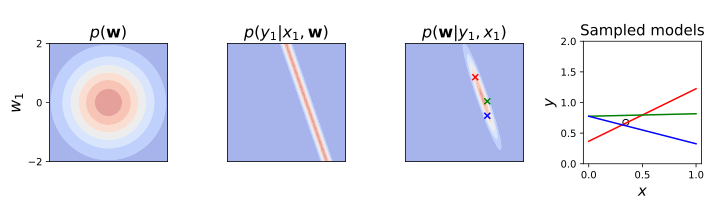

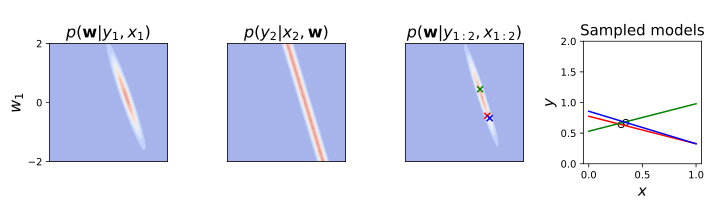

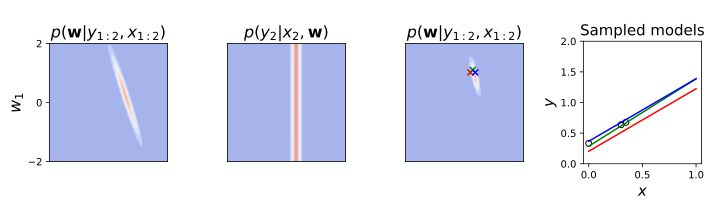

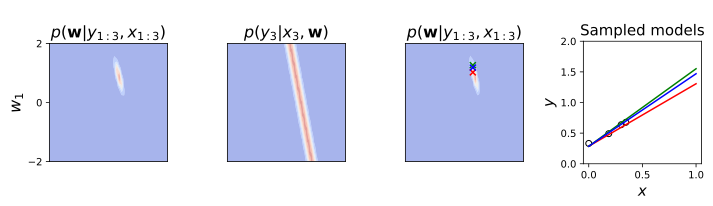

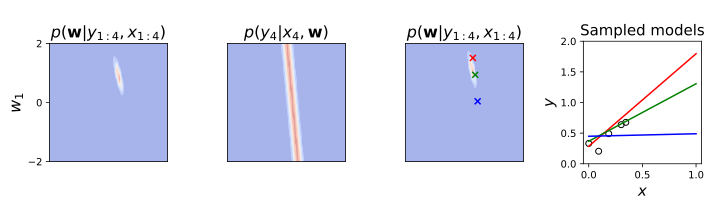

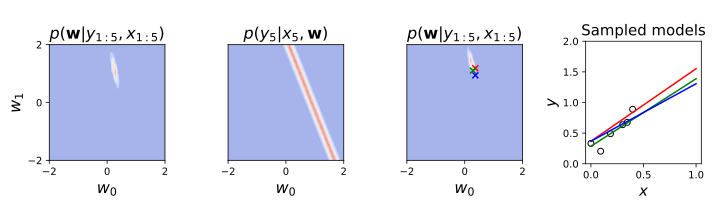

In [15]:
# Input locations at which to plot sampled lines
x_plot = np.linspace(0, 1, 100)

# Colors used for plotting the sampled lines
colours = ['red', 'green', 'blue']

# Initilialise grid
log_prior = - 0.5 * np.sum(w_grid.dot(np.eye(2)) * w_grid, axis=2) / var_w

# Run online learning for a certain number of points
for n in range(num_points+1):

    # Design matrix -- in online learning it contains a single datum
    X = np.array([[x_data[n] ** d for d in range(0, 2)]])
        
    # Grid of the log-likelihood of the current datapoint -- shape (50, 50)
    log_lik = -0.5 * np.sum((y_data[n] - w_grid.dot(X.T)) ** 2, axis=2) / var_y
    
    # Grid of the updated (unnormalised) log-posterior -- shape (50, 50)
    log_post = log_prior + log_lik

    # Add new figure to plot
    fig = plt.figure(figsize = (10, 3))
    
    # Plot the log-prior, log-likelihood and log-posterior
    for i, values in enumerate([log_prior, log_lik, log_post]):
        
        # Plot in the appropriate subplot
        subplot = plt.subplot(1, 4, i + 1)
        values = np.exp(values - np.amax(values))
        
        # Plot the grid
        plt.contourf(w1_range, w2_range, values, cmap = 'coolwarm', alpha = 0.5)
        subplot.set_aspect('equal', 'box')
        
        title = get_plot_title_bayesian_online_learning(n, i)
        plt.title(title, fontsize=16)

        # Format ticks of posterior plots
        if n < num_points:
            plt.xticks([])
        else:
            plt.xticks([-2, 0, 2])
            plt.xlabel("$w_0$", fontsize=16)
            
        if i == 1 or i == 2:
            plt.yticks([])
        else:
            plt.yticks([-2, 0, 2])
            plt.ylabel("$w_1$", fontsize=16)

         
    # Lists to store sampled weights
    w1_list = []
    w2_list = []
    
    # Discretised posterior distribution on grid
    post = np.exp(log_post)
    post = post / post.sum()
    
    # Loop to plot sampled models, each time sampling (w1, w2) from the grid
    for i in range(3):
        
        # Reshape posterior probabilities to a (100*100) vector
        p = post.flatten()
        
        # Sample the index of the point to be sampled
        idx = np.random.choice(np.arange(p.shape[0]), p=p)
        w1, w2 = w_grid.reshape((-1, 2))[idx]
        
        # Plot sampled weights
        plt.scatter(w1, w2, marker = 'x', color = colours[i])
        
        w1_list.append(w1)
        w2_list.append(w2)
        
    # Plot linear models corresponding to sampled weights
    plt.subplot(144)
    for i in range(3):
        plt.plot(x_plot, w1_list[i] + w2_list[i] * x_plot, color=colours[i])
    
    # Plot observed data
    plt.scatter(x_data[:n + 1], y_data[:n + 1], marker = 'o', facecolor = 'None', edgecolor = 'black')
    
    # Format plot
    plt.ylim([0, 2])
        
    plt.xlabel("$x$", fontsize=15)
    plt.ylabel("$y$", fontsize=15)
    
    plt.title("\nSampled models", fontsize=15)
    
    log_prior = log_post.copy()
    
    plt.tight_layout()

plt.show()

The first row of figures above shows contour plots of the prior ($p(w_0, w_1)$, first plot, leftmost), the likelihood for the first datapoint ($p(y_1|x_1,w_0,w_1)$, second), and the posterior after seeing the first datapoint ($p(w_0,w_1|x_1,y_1)$, third) plotted as a function of the intercept ($w_0$) and gradient ($w_1$). The fourth plot (rightmost) shows the datapoint $\{x_1,y_1\}$. Samples from the posterior distribution are shown by coloured crosses (third plot) and the corresponding straight lines are shown on the right. When one datapoint is seen, the settings of the weight corresponding to straight lines that pass close to the datapoint will have high mass under the posterior. In this instance, that is lines with positive gradient that have an intercept with a low value or lines with a negative gradient and a high valued intercept. This is the reason why the posterior is fairly diffuse - a single datapoint cannot pin down the parameters by itself - and correlated.

The second row of figures shows the same quantities once the second datapoint is observed. On the left is the 'prior' (the previous posterior), next is the likelihood for the new data point, then the posterior with three samples, and finally the data with the sampled straight lines. The new datapoint in this case has a similar input location to the old one, so it does not provide much additional information about the parameters. Notice though that the posterior has narrowed slightly as we become more confident.

The third datapoint (third row) does have a different input location from the other two. It consequently suggests that the line has positive graident and a relatively low value for the intercept. The posterior collapses, not largely confined to the postive quadrant. The posterior samples all have postive gradient. 

As more data arrive (lower rows) the posterior narrows down, and the weights are constrained to a progressively smaller area. This is caused by the likelihoods that act as soft constraints ruling out more and more of parameter space. This collapse is reflected in the data space where the lines corresponding to posterior samples show less variability.

We have concluded the chapters on regression. In the [next chapter](../classification/classification_intro.ipynb), on classification you will look at different approaches to the classification of data points.

### Summary

We saw how Bayesian updates naturally support online or incremental learning. The old posterior is multiplied by the new likelihood and renormalised to get the new posterior. Over the course of online learning, the posterior typically evolves from a diffuse initial prior, through to a concentrated posterior as more data arrive and the likelihood functions rule out many parameter settings.

<br>